# 4 – Topic Modeling with LDA

In this section, **Latent Dirichlet Allocation (LDA)** models are built and trained to identify the key topics discussed by users across the banking apps.  
LDA is applied as an unsupervised learning technique to uncover hidden thematic structures in large collections of text, making it suitable for analysing review content at scale.

### Libraries and Imports

In [17]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import re
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

from pathlib import Path
import joblib

In [2]:
path = "D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_sentiment.parquet"
df_sentiment = pd.read_parquet(path)
print(f"df shape: {df_sentiment.shape}")
df_sentiment.head(2)

df shape: (660848, 20)


,ID,app,score,review_text,review_text_clean,review_date,year,thumbs_up,replied,reply_text,reply_text_clean,reply_date,time_to_reply(h),app_version_head,app_version_detail,review_sentiment,review_sentiment_label,Consistent,reply_sentiment,reply_sentiment_label
0,1,Santander,4,What is the policy in regard to root/custom ROMs?,what is the policy in regard to root/custom roms?,2025-12-09 03:08:56,2025,0,0,None,None,NaT,NaN,5,29.0,0.0000,neutral,1,NaN,undefined
1,2,Santander,1,Depositing a cheque most difficult thing to do...,depositing a cheque most difficult thing to do...,2025-12-08 23:44:12,2025,0,0,None,None,NaT,NaN,5,29.0,-0.1744,negative,1,NaN,undefined


## 4.1 – Training the General Model

The objective of this notebook is to identify the most frequent **pain points** highlighted in negative reviews and the key **strengths** emphasized in positive reviews. The analysis focuses exclusively on **user-generated reviews**, discarding bank replies, and **inconsistent cases** are removed—such as reviews with negative scores but positive sentiment, or the reverse.

A copy of `df_sentiment` will be used for this analysis, and all transformations will be consolidated at the end to ensure reproducibility.

In [3]:
df = df_sentiment.copy()

### 4.1.1. - Text Cleaning and Preprocessing

Text cleaning and preprocessing constitute a critical step for extracting meaningful topics.

As an initial action, all **inconsistent cases will be removed** - that is, reviews in which the assigned score and the computed sentiment do not align.

In [4]:
print(f"Shape before removal of inconsistent cases: {df.shape}")

# Remove contradictory rows
df_model = df[df['Consistent']==1].copy()

print(f"Shape after of inconsistent cases: {df_model.shape}")

Shape before removal of inconsistent cases: (660848, 20)
Shape after of inconsistent cases: (622315, 20)


The following step applies **text cleaning and preprocessing** procedures.  
A copy of the original text is retained in the `text` column to support later interpretation.

In [5]:
# Additional text cleaning / prior cleaning was already done in the cleaning function in notebook 2
def text_cleaner(x):
    if not isinstance(x, str):
        return pd.NA
    t = x
    t = re.sub(r'@\w+', ' ', t)                 # remove @mentions
    t = re.sub(r'\d+', ' <num> ', t)            # numbers -> <num>
    t = re.sub(r'[^a-z\s<>]+', ' ', t)          # keep letters, spaces, and <> so <num> survives
    t = re.sub(r'\s+', ' ', t).strip()          # normalize whitespace
    return t if t else pd.NA

# Apply cleaning
df_model['review_extra_clean'] = df_model['review_text_clean'].map(text_cleaner)

print(f"Shape after text_cleaner: {df_model.shape}")

Shape after text_cleaner: (622315, 21)


In [6]:
# Drop ultra-short reviews (fewer than 2 tokens)
df_model = df_model[df_model['review_extra_clean'].str.split().str.len() >= 2]

print(f"Shape after removing ultra-short reviews: {df_model.shape}")

Shape after removing ultra-short reviews: (531244, 21)


In [7]:
# Remove stop words --> words that can occur frequently but do not provide useful insight in the context of this analysis

# Domain stopwords
domain_sw = {
    'app','apps','bank','account','application', 'mobile', 'banks', 'santander', 'uk', 
    'lloyds', 'hsbc', 'revolut', 'barclays', 'monzo', 'banks', 'thanks', 'ive', 'num',
}

# Merge English + domain stopwords into a list
stop_words = list(ENGLISH_STOP_WORDS.union(domain_sw))

### 4.1.2. — LDA Trained on All Reviews

**Latent Dirichlet Allocation (LDA)** will be applied for topic modeling. LDA is a **generative probabilistic model** designed to uncover hidden topics within a collection of documents—in this case, user reviews. Briefly, LDA defines topics based on word distributions and represents each document (review) as a probability distribution over these topics.

A **three-stage approach** will be employed for LDA training and fine-tuning:

1. Run LDA with 10 topics and evaluate the top words for each topic.  
2. Refine stop words by removing high-frequency words that do not provide additional value, then re-run LDA.  
3. Test different values of `n` (number of topics) and select the most interpretable model, assigning the dominant topic to each review.

**I. Initial LDA Run with 10 Topics**

Initially, **functions will be defined** to build the vectorizer, run LDA, and display results, ensuring reproducibility.

**Note:** For **vectorization**—transforming text into a document-term matrix (DTM)—the **Count Vectorizer Bag-of-Words** method will be used, as it is particularly suitable for LDA.

In [8]:
# Build vectorizer in case you've updated stopwords later
def build_vectorizer(stop_words, ngram_range=(1,2), min_df=20, max_df=0.5):
    return CountVectorizer(
        preprocessor=None,
        token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
        stop_words=stop_words,
        ngram_range=ngram_range,
        min_df=min_df,
        max_df=max_df
    )

# Run LDA
def fit_lda(X, n_topics=10, max_iter=10, random_state=42, n_jobs=-1):
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=max_iter,
        learning_method='batch',
        random_state=random_state,
        n_jobs=n_jobs
    )
    t0 = time()
    lda.fit(X)
    print(f"LDA fit done: {n_topics} topics in {time() - t0:.1f}s")
    return lda

# Print Top Words
def print_top_words(model, feature_names, n_top=12, title=None):
    if title:
        print(title)
    for t, comp in enumerate(model.components_):
        top_idx = comp.argsort()[-n_top:][::-1]
        print(f"Topic {t:02d}: " + " | ".join(feature_names[top_idx]))
    print()

The LDA model can now be executed, initially testing with **10 topics**.

In [9]:
# Build X for baseline run (10 topics)
vectorizer = build_vectorizer(stop_words)      
X = vectorizer.fit_transform(df_model['review_extra_clean'])
vocab = vectorizer.get_feature_names_out() # used later on to print top words

In [10]:
# Run LDA
lda_10 = fit_lda(X, n_topics=10)

LDA fit done: 10 topics in 294.5s


The top words for each topic will now be examined to interpret the themes captured by the model.

In [11]:
print_top_words(lda_10, vocab, n_top=12)

Topic 00: great | love | fast | convenient | money | exchange | abroad | currency | rates | card | super | transfers
Topic 01: good | banking | like | service | online | useful | really | far | online banking | really good | good service | far good
Topic 02: easy | money | great | accounts | banking | way | transfer | need | payments | manage | access | transactions
Topic 03: user | does | friendly | nice | user friendly | service | customer | need | customer service | fantastic | security | problem
Topic 04: easy | use | easy use | quick | simple | quick easy | navigate | great | great easy | easy navigate | good easy | simple use
Topic 05: excellent | service | efficient | helpful | reliable | day | time | excellent service | fast | using | safe | online
Topic 06: best | works | banking | problems | far | perfect | used | amazing | better | really | best banking | issues
Topic 07: just | new | like | use | brilliant | secure | easier | features | lot | happy | crypto | paying
Topic 0

The results indicate that several words still do not contribute meaningful insights and should be removed (i.e., added to the stop words) to avoid polluting the topic modeling process and to extract relevant themes.

**II. Stopword Refinement and LDA Re-Run**

Additional words that negatively impact topic quality are added to the `stop_words` list.  
This refinement process was repeated multiple times throughout the project to optimize the model.

In [12]:
domain_extra = {
    'able', 'absolutely', 'accounts', 'add', 'ago', 'alot', 'allows', 'amazing', 'anymore', 'appropriate','awesome', 'bad', 'banking', 
    'best', 'better', 'bit', 'branch', 'brilliant', 'business', 'change', 'cheque', 'cheques','clear', 'close', 'complicated', 
    'convenient', 'constantly', 'daily', 'date', 'day', 'days', 'definitely', 'did', 'didnt', 'different', 'difficult', 'does', 
    'doesnt', 'doing', 'dont', 'ease', 'easier', 'easily', 'easy', 'effective', 'efficient', 'especially', 'exactly', 'excellent', 
    'experience', 'extremely', 'fab', 'fantastic', 'far', 'fast', 'feels','finances', 'fine', 'fix', 'follow', 'forward', 'getting', 
    'gives', 'going', 'good', 'google', 'got', 'great', 'guys', 'handy', 'happy', 'havent', 'having', 'hassle', 'hello', 'helpful', 
    'helps', 'highly', 'hope', 'hoping', 'improved', 'isnt', 'issues', 'job', 'just','keeping', 'keeps', 'know', 'latest', 'let', 
    'lets', 'life', 'like', 'little', 'live', 'long', 'longer', 'lot', 'lots', 'love', 'loving','make', 'makes', 'making', 'month', 
    'months', 'need', 'needed', 'needs', 'neo', 'new', 'nice', 'number', 'old', 'online','open', 'overall', 'payees', 'pending', 
    'people', 'perfect', 'perfectly', 'place', 'pleased', 'poor', 'pretty', 'quick', 'quickly', 'quite', 'really', 'reason', 
    'recommend', 'recommended', 'reliable', 'rooted', 'round', 'rubbish', 'safe', 'satisfied', 'saves', 'say', 'says', 'set', 
    'simple', 'simpler', 'simply', 'slow', 'smooth', 'sort', 'star', 'stars', 'stopped', 'straighforward', 'straight', 
    'straightforward', 'stuff', 'super', 'superb', 'sure', 'takes', 'team', 'terrible', 'thank', 'thats', 'think', 'thing', 
    'things', 'time', 'times', 'tin', 'tried', 'try', 'trying', 'unable', 'understand', 'use', 'used', 'useful', 'useless', 
    'using', 'usually', 'want', 'way', 'website', 'went', 'whats', 'wish', 'wonderful', 'wont', 'work', 'worked', 'working', 'works', 
    'worst', 'wrong', 'years'
}

stop_words = list(set(stop_words).union(domain_extra))

Reviews that consist exclusively of stop words are removed from the dataset.

In [13]:
tmp_vec = CountVectorizer(
    preprocessor=None,
    token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
    stop_words=stop_words,
    ngram_range=(1,1)
)
analyze = tmp_vec.build_analyzer()

min_tokens_after_sw = 1
mask = df_model['review_extra_clean'].astype(str).map(lambda s: len(analyze(s)) >= min_tokens_after_sw)
print("Rows dropped after SW filter:", int((~mask).sum()))
df_model = df_model[mask].copy()
print(f"New df_model shape: {df_model.shape}")

Rows dropped after SW filter: 201746
New df_model shape: (329498, 21)


In [14]:
vectorizer = build_vectorizer(stop_words)
X = vectorizer.fit_transform(df_model['review_extra_clean'])
vocab = vectorizer.get_feature_names_out()

**III. Testing Different `n_topics` and Evaluating Results**

In this stage, multiple models with varying `n_topics` will be trained using a hold-out split for evaluation.

Initially, the dataset is split to ensure a fair comparison across models.

In [15]:
X_train, X_valid = train_test_split(X, test_size=0.20, random_state=42)

A range of potential topic numbers (`n_topics`) will be trained to determine the most interpretable model.

In [16]:
candidate_topics = [5, 6, 7, 8, 9]  
lda_models = {}
rows = []

for k in candidate_topics:
    model = fit_lda(X_train, k)
    lda_models[k] = model
    rows.append({
        "k": k,
        "perplexity_train": model.perplexity(X_train),  # lower = better
        "perplexity_valid": model.perplexity(X_valid),  # lower = better
        "elbo_train": model.score(X_train),             # higher = better
        "elbo_valid": model.score(X_valid)              # higher = better
    })

metrics_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
display(metrics_df)

LDA fit done: 5 topics in 140.3s
LDA fit done: 6 topics in 134.6s
LDA fit done: 7 topics in 125.7s
LDA fit done: 8 topics in 131.1s
LDA fit done: 9 topics in 154.8s


,k,perplexity_train,perplexity_valid,elbo_train,elbo_valid
0,5,1975.408937,2360.096966,-1.042889e+07,-2.674644e+06
1,6,1980.211887,2408.586042,-1.043222e+07,-2.681648e+06
2,7,1983.880000,2450.583142,-1.043477e+07,-2.687601e+06
3,8,1986.280558,2497.377808,-1.043643e+07,-2.694115e+06
4,9,2004.570611,2557.986166,-1.044903e+07,-2.702373e+06


The validation perplexity will be visually evaluated to assess model performance across different numbers of topics.

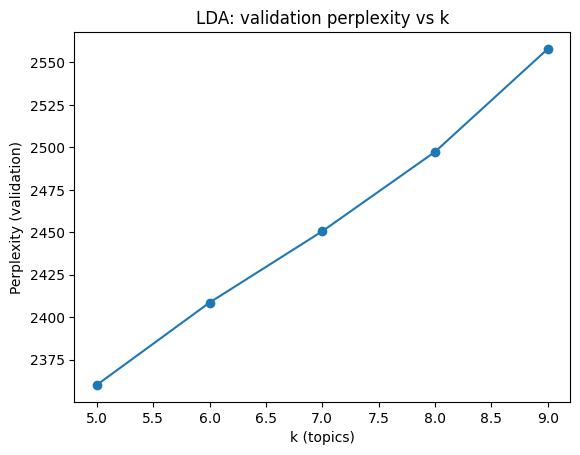

In [18]:
plt.plot(metrics_df["k"], metrics_df["perplexity_valid"], marker="o")
plt.xlabel("k (topics)")
plt.ylabel("Perplexity (validation)")
plt.title("LDA: validation perplexity vs k")
plt.show()

The perplexity analysis reveals a **monotonically increasing trend** as the number of topics (k) grows from 5 to 9, suggesting that **model complexity increases without corresponding improvements in interpretability**.

**Perplexity results:**
- k=5: 2,360 (lowest perplexity)
- k=6: 2,409
- k=7: 2,451
- k=8: 2,497
- k=9: 2,558 (highest perplexity)

**Key insight**: Lower perplexity typically indicates better model fit, making **k=5 the optimal choice** for this dataset. This suggests that customer reviews naturally cluster into approximately 5 distinct thematic topics. Increasing beyond 5 topics adds complexity without meaningful gains, likely resulting in topic fragmentation or overlap that reduces interpretability.

The top words for each topic will be reviewed manually to assess interpretability and select the optimal number of topics.

In [19]:
for k in candidate_topics:
    print_top_words(lda_models[k], vocab, n_top=12, title=f"\n=== k={k} ===")


=== k=5 ===
Topic 00: card | money | transfer | pay | exchange | payment | rates | currency | transfer money | don | cards | credit
Topic 01: service | customer | problems | support | customer service | help | chat | code | problem | features | issue | contact
Topic 02: update | navigate | log | phone | doesn | access | don | balance | screen | login | version | notifications
Topic 03: user | friendly | user friendly | payments | phone | transfers | pay | crypto | intuitive | contactless | interface | direct
Topic 04: money | secure | transactions | manage | services | spending | problem | send | abroad | track | travel | save


=== k=6 ===
Topic 00: card | money | transfer | exchange | pay | transfer money | rates | currency | payment | cards | credit | don
Topic 01: service | customer | problems | support | help | customer service | chat | problem | contact | features | issue | couldn
Topic 02: update | navigate | log | doesn | don | phone | screen | login | version | access | notif

**✅ Running the Selected Model and Saving Results**

Analysis of the top keywords for each candidate `k` indicates that a lower number of topics produces more coherent themes than higher values.  
Considering both validation perplexity scores and manual interpretation, **7 topics** were selected as the optimal choice for the final LDA model.

In [20]:
chosen_k = 7

# Train model with selected parameters
lda_best = fit_lda(X, n_topics=chosen_k)

LDA fit done: 7 topics in 155.3s


In [21]:
# print topics for k=7
print_top_words(lda_best, vocab, n_top=12)

Topic 00: card | money | don | payment | cards | credit | pay | credit card | free | virtual | funds | lost
Topic 01: service | customer | problems | customer service | support | help | chat | issue | problem | contact | couldn | features
Topic 02: update | navigate | log | doesn | don | screen | login | version | access | fingerprint | updates | crashes
Topic 03: phone | payments | pay | transfers | intuitive | contactless | payment | direct | samsung | won | android | staff
Topic 04: money | secure | abroad | services | transactions | send | travel | spending | save | saving | feel | travelling
Topic 05: paying | check | crypto | access | transaction | balance | bills | payments | pay | transferring | money | high
Topic 06: user | transfer | friendly | money | user friendly | exchange | security | manage | transfer money | rates | currency | problem



In [23]:
# Save
joblib.dump(lda_best, "D:/Digital-Banking-Dashboard/assets/models/lda/lda_final_ALL.pkl")
joblib.dump(vectorizer, "D:/Digital-Banking-Dashboard/assets/models/lda/vectorizer_final_ALL.pkl")
print("✅ Files saved")

✅ Files saved


## 4.2 – Training the Segmented Model

### 4.2.1 – LDA Trained on Negative Reviews Only

An LDA model will now be trained exclusively on reviews with negative sentiment to extract more meaningful insights regarding **pain points** for each app.

In [24]:
df_neg = df_model[df_model['review_sentiment_label'] == 'negative'].copy()

print(f"df_model shape: {df_model.shape}")
print(f"df_neg shape: {df_neg.shape}")

df_model shape: (329498, 21)
df_neg shape: (45482, 21)


**I. INITIAL RUN OF LDA WITH 10 TOPICS**

In [25]:
vectorizer_neg = build_vectorizer(stop_words)
X_neg = vectorizer_neg.fit_transform(df_neg['review_extra_clean'])
vocab_neg = vectorizer_neg.get_feature_names_out()

lda_neg_10 = fit_lda(X_neg, n_topics=10)
print_top_words(lda_neg_10, vocab, n_top=12, title ="Top words @ 10 topics")

LDA fit done: 10 topics in 25.5s
Top words @ 10 topics
Topic 00: cryptocurrency trading | currency exchanges | data wifi | banque | facile | calm | face | angles | borders | barcleys | excited | conversion
Topic 01: conversion | agent chat | aboard | alphabetical order | facile | affairs | excelent service | fixed problem | card wait | away home | assigned | competitor
Topic 02: buy phone | ate | customise | compliance | crypto trading | card gpay | complains | contacting support | borders | biometric log | departments | deadline
Topic 03: driving | base | bases | boy | excelent service | conversion | aps | basic features | charged fee | courteous | dyslexic | certain transactions
Topic 04: features customer | complains | accessing money | don worry | card transactions | balances | aboard | balances payments | customise | don problem | flip | feel confident
Topic 05: cryptocurrency trading | answers | conversion | facile | card didn | apple pay | boy | access money | anoying | delete p

**II. Finetune stopwords and re-run LDA**

In [26]:
neg_extra = {
    'abd','abit','according','address','anoying','annoying','approximately','appit',
    'applies','arbitrary','arise','aspects','awful','awhile','awkward','bare','bardzo',
    'barclaycard','based','basis','banki','began','begin','believe','barely',
    'bloody','boys','buys','centres','consider','constantly','continue','continually',
    'contrary','cool','corporate','cos','couple','covered','damn','dave','dear',
    'decades','dedicated','depend','der','des','difficult','die','dinosaur',
    'dirty','dislike','dosnt','email','exist','faced','fairly','firstly','fix',
    'frustrating','fyi','goto','half','hanging','hate','heavy','heard', 'infuriating',
    'minutes','poor','saying','waste','hello','worse','wouldnt'
}

stop_words_neg = list(set(stop_words).union(neg_extra))

In [27]:
vectorizer_neg = build_vectorizer(stop_words_neg, ngram_range=(1,2), min_df=25, max_df=0.6)
X_neg = vectorizer_neg.fit_transform(df_neg['review_extra_clean'])
vocab_neg = vectorizer_neg.get_feature_names_out()

In [28]:
tmp_vec = CountVectorizer(
    preprocessor=lambda x: x,
    token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
    stop_words=stop_words_neg,
    ngram_range=(1,1)
)
analyze = tmp_vec.build_analyzer()

min_tokens_after_sw = 1
mask = df_neg['review_extra_clean'].map(lambda s: len(analyze(s)) >= min_tokens_after_sw)
print("Dropped after SW-length filter:", int((~mask).sum()))
df_neg = df_neg[mask].copy()

Dropped after SW-length filter: 237


**III. Test different `n_topics` and evaluate results**

In [29]:
Xtr, Xva = train_test_split(X_neg, test_size=0.2, random_state=42)

In [30]:
candidate_negtopics = [4,5,6,7,8]
lda_models, rows = {}, []

for k in candidate_negtopics:
    model = fit_lda(Xtr, k)
    lda_models[k]=model
    rows.append({
        "k": k,
        "perplexity_train": model.perplexity(Xtr),  # lower = better
        "perplexity_valid": model.perplexity(Xva),  # lower = better
        "elbo_train": model.score(Xtr),             # higher = better
        "elbo_valid": model.score(Xva)              # higher = better
    })

neg_metrics_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
display(neg_metrics_df)

LDA fit done: 4 topics in 22.7s
LDA fit done: 5 topics in 22.5s
LDA fit done: 6 topics in 21.5s
LDA fit done: 7 topics in 21.2s
LDA fit done: 8 topics in 20.6s


,k,perplexity_train,perplexity_valid,elbo_train,elbo_valid
0,4,1115.944004,1377.761485,-2.160499e+06,-550074.416242
1,5,1121.442669,1440.645944,-2.162013e+06,-553470.919209
2,6,1125.931128,1497.520503,-2.163242e+06,-556417.485808
3,7,1137.591782,1553.785036,-2.166414e+06,-559224.331959
4,8,1137.617620,1596.098328,-2.166421e+06,-561269.028307


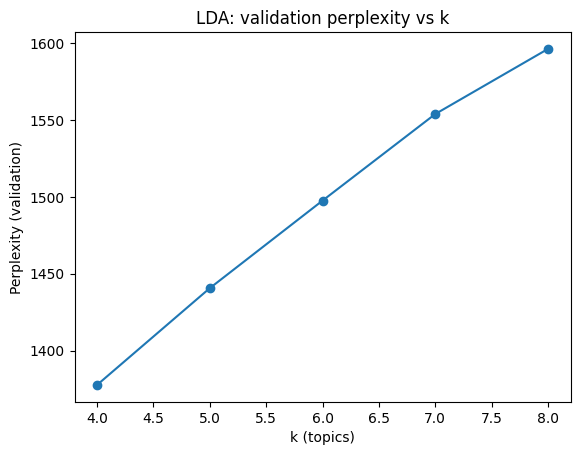

In [31]:
plt.plot(neg_metrics_df["k"], neg_metrics_df["perplexity_valid"], marker="o")
plt.xlabel("k (topics)")
plt.ylabel("Perplexity (validation)")
plt.title("LDA: validation perplexity vs k")
plt.show()

In [32]:
for k in candidate_negtopics:
    print_top_words(lda_models[k], vocab_neg, n_top=12, title=f"\n=== k={k} ===")


=== k=4 ===
Topic 00: money | don | transfer | access | code | security | verify | verification | send | hard | sent | doesn
Topic 01: service | customer | support | customer service | chat | money | contact | blocked | help | don | hours | problem
Topic 02: update | phone | log | problem | doesn | error | login | screen | access | android | problems | crashes
Topic 03: card | pay | payment | money | payments | transactions | don | paying | transaction | balance | transfer | option


=== k=5 ===
Topic 00: money | transfer | access | code | don | security | verify | verification | details | sent | send | asking
Topic 01: service | customer | customer service | support | chat | money | contact | blocked | help | don | hours | services
Topic 02: phone | log | update | doesn | problem | login | android | access | pay | crashes | won | fingerprint
Topic 03: card | pay | payment | money | payments | transactions | transaction | don | transfer | paying | credit | send
Topic 04: update | don 

**✅ RUN SELECTED MODEL AND SAVE RESULTS**

In [33]:
chosen_k_neg = 6

lda_best_neg = fit_lda(X_neg, n_topics=chosen_k_neg)

print_top_words(lda_best_neg, vocab_neg, 12)

LDA fit done: 6 topics in 27.2s
Topic 00: money | code | access | security | details | verify | verification | password | don | sent | process | asking
Topic 01: service | customer | customer service | money | support | don | chat | blocked | contact | avoid | funds | services
Topic 02: phone | log | update | login | android | crashes | fingerprint | access | doesn | screen | problem | device
Topic 03: card | money | pay | transfer | payment | transaction | transactions | send | don | credit | lost | fees
Topic 04: update | user | don | problems | screen | error | balance | hard | version | confusing | recent | previous
Topic 05: phone | problem | pay | doesn | payments | contactless | chat | help | card | support | payment | contact



In [34]:
# Save
joblib.dump(lda_best_neg, "D:/Digital-Banking-Dashboard/assets/models/lda/lda_final_NEG.pkl")
joblib.dump(vectorizer_neg, "D:/Digital-Banking-Dashboard/assets/models/lda/vectorizer_final_NEG.pkl")
print("✅ Files saved")

✅ Files saved


### 4.2.2 – LDA Trained on Positive Reviews Only

Finally, an LDA model will be trained exclusively on reviews with positive sentiment to extract more meaningful insights regarding **strengths** for each app.

In [35]:
df_pos = df_model[df_model['review_sentiment_label'] == 'positive'].copy()

print(f"df_model shape: {df_model.shape}")
print(f"df_neg shape: {df_pos.shape}")

df_model shape: (329498, 21)
df_neg shape: (239988, 21)


**I. INITIAL RUN OF LDA WITH 10 TOPICS**

In [36]:
vectorizer_pos = build_vectorizer(stop_words)
X_pos = vectorizer_pos.fit_transform(df_pos['review_extra_clean'])
vocab_pos = vectorizer_pos.get_feature_names_out()

lda_pos_10 = fit_lda(X_pos, n_topics=10)
print_top_words(lda_pos_10, vocab_pos, n_top=12, title ="Top words @ 10 topics")

LDA fit done: 10 topics in 99.5s
Top words @ 10 topics
Topic 00: update | available | phone | doesn | pay | version | screen | android | don | updated | updates | information
Topic 01: navigate | exchange | rates | currency | abroad | transactions | rate | travelling | exchange rates | fees | currencies | transaction
Topic 02: service | customer | services | customer service | operate | accessible | staff | secured | options | quality | professional | print
Topic 03: money | transfer | problem | features | transfer money | send | friends | free | family | send money | sending | support
Topic 04: secure | user | friendly | user friendly | intuitive | pay | interface | bills | feel | pay bills | flexible | faster
Topic 05: access | crypto | transfers | control | paying | direct | instant | functionality | world | functions | transactions | trading
Topic 06: manage | card | money | track | travel | spending | save | spend | started | lost | notifications | manage money
Topic 07: payments 

**II. Finetune stopwords and re-run LDA**

In [37]:
pos_extra = {'lovely'} #

stop_words_pos = list(set(stop_words).union(pos_extra))

In [38]:
vectorizer_pos = build_vectorizer(stop_words_pos, ngram_range=(1,2), min_df=25, max_df=0.6)
X_pos = vectorizer_pos.fit_transform(df_pos['review_extra_clean'])
vocab_pos = vectorizer_pos.get_feature_names_out()

In [39]:
tmp_vec = CountVectorizer(
    preprocessor=lambda x: x,
    token_pattern=r'(?u)\b[a-z<][a-z<>-]{2,}\b',
    stop_words=stop_words_pos,
    ngram_range=(1,1)
)
analyze = tmp_vec.build_analyzer()

min_tokens_after_sw = 1
mask = df_pos['review_extra_clean'].map(lambda s: len(analyze(s)) >= min_tokens_after_sw)
print("Dropped after SW-length filter:", int((~mask).sum()))
df_pos = df_pos[mask].copy()

Dropped after SW-length filter: 410


**III. Test different `n_topics` and evaluate results**

In [40]:
Xtr, Xva = train_test_split(X_pos, test_size=0.2, random_state=42)

In [41]:
candidate_postopics = [4,5,6,7,8]
lda_models, rows = {}, []

for k in candidate_postopics:
    model = fit_lda(Xtr, k)
    lda_models[k]=model
    rows.append({
        "k": k,
        "perplexity_train": model.perplexity(Xtr),  # lower = better
        "perplexity_valid": model.perplexity(Xva),  # lower = better
        "elbo_train": model.score(Xtr),             # higher = better
        "elbo_valid": model.score(Xva)              # higher = better
    })

pos_metrics_df = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
display(pos_metrics_df)

LDA fit done: 4 topics in 82.6s
LDA fit done: 5 topics in 80.9s
LDA fit done: 6 topics in 83.9s
LDA fit done: 7 topics in 93.8s
LDA fit done: 8 topics in 83.9s


,k,perplexity_train,perplexity_valid,elbo_train,elbo_valid
0,4,1281.589228,1485.013701,-5.899674e+06,-1.521026e+06
1,5,1289.002750,1520.517749,-5.904430e+06,-1.525947e+06
2,6,1261.390558,1508.138211,-5.886577e+06,-1.524244e+06
3,7,1270.632171,1538.622389,-5.892595e+06,-1.528412e+06
4,8,1267.513373,1557.324436,-5.890569e+06,-1.530928e+06


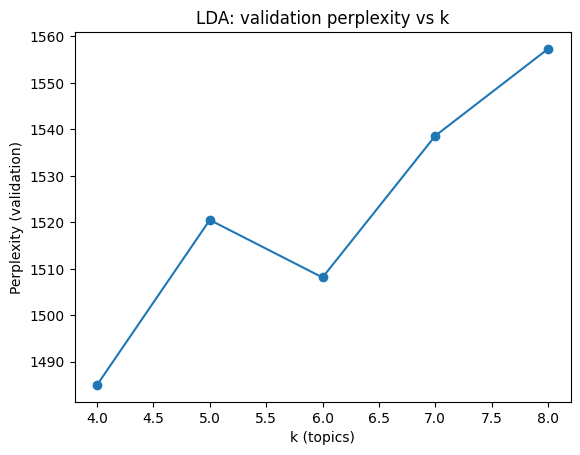

In [42]:
plt.plot(pos_metrics_df["k"], pos_metrics_df["perplexity_valid"], marker="o")
plt.xlabel("k (topics)")
plt.ylabel("Perplexity (validation)")
plt.title("LDA: validation perplexity vs k")
plt.show()

In [43]:
for k in candidate_postopics:
    print_top_words(lda_models[k], vocab_pos, n_top=12, title=f"\n=== k={k} ===")


=== k=4 ===
Topic 00: card | money | user | friendly | user friendly | exchange | manage | abroad | rates | currency | travel | send
Topic 01: money | transfer | navigate | payments | access | transfer money | check | pay | balance | control | services | friends
Topic 02: problems | phone | update | don | problem | support | help | payment | log | issue | pay | doesn
Topic 03: service | secure | security | features | customer | transactions | customer service | crypto | intuitive | options | interface | financial


=== k=5 ===
Topic 00: card | money | user | friendly | user friendly | exchange | manage | rates | currency | rate | send | credit
Topic 01: money | transfer | access | transfer money | check | pay | balance | payments | services | friends | bills | paying
Topic 02: problems | phone | update | don | support | help | payment | log | issue | pay | doesn | payments
Topic 03: service | secure | security | customer | features | customer service | intuitive | interface | staff | 

**✅ RUN SELECTED MODEL AND SAVE RESULTS**

In [44]:
chosen_k_pos = 6

lda_best_pos = fit_lda(X_pos, n_topics=chosen_k_pos)

print_top_words(lda_best_pos, vocab_pos, 12)

LDA fit done: 6 topics in 116.5s
Topic 00: card | money | exchange | manage | rates | currency | send | rate | credit | track | cards | cash
Topic 01: money | transfer | access | transfer money | check | pay | balance | bills | friends | payments | paying | family
Topic 02: phone | update | don | support | help | payment | issue | log | doesn | pay | payments | chat
Topic 03: service | secure | security | customer | customer service | features | intuitive | staff | feel | everyday | line | lloyd
Topic 04: navigate | transfers | transactions | crypto | payments | options | abroad | features | travel | international | spending | travelling
Topic 05: user | friendly | user friendly | problems | problem | services | interface | managing | practical | accessible | features | flexible



In [45]:
# Save
joblib.dump(lda_best_pos, "D:/Digital-Banking-Dashboard/assets/models//lda/lda_final_POS.pkl")
joblib.dump(vectorizer_pos, "D:/Digital-Banking-Dashboard/assets/models//lda/vectorizer_final_POS.pkl")
print("✅ Files saved")

✅ Files saved


## 4.3. - Evaluation of Results

The final LDA models will now be evaluated on the dataset.  

All transformations are encapsulated within the `apply_ldas` function to ensure reproducibility.

In [46]:
def apply_ldas(
    df: pd.DataFrame,
    text_col: str = "review_text_clean",
    # Model file paths
    lda_path: str = "D:/Digital-Banking-Dashboard/assets/models/lda/lda_final_ALL.pkl",
    vect_path: str = "D:/Digital-Banking-Dashboard/assets/models/lda/vectorizer_final_ALL.pkl",
    lda_neg_path: str = "D:/Digital-Banking-Dashboard/assets/models/lda/lda_final_NEG.pkl",
    vect_neg_path: str = "D:/Digital-Banking-Dashboard/assets/models/lda/vectorizer_final_NEG.pkl",
    lda_pos_path: str = "D:/Digital-Banking-Dashboard/assets/models/lda/lda_final_POS.pkl",
    vect_pos_path: str = "D:/Digital-Banking-Dashboard/assets/models/lda/vectorizer_final_POS.pkl",
    inplace: bool = True,
) -> pd.DataFrame:
    """
    Apply three LDA models to the dataframe:
    - Generic model (all reviews)
    - Negative-only model (scores 1-2)
    - Positive-only model (scores 4-5)
    Returns dataframe with topic assignments and probabilities.
    """
    if not inplace:
        df = df.copy()

    print(f"Initial shape: {df.shape}")

    # Text cleaning preprocessing
    def text_cleaner(x):
        if not isinstance(x, str):
            return pd.NA
        t = x
        t = re.sub(r"@\w+", " ", t)                  # Remove @mentions
        t = re.sub(r"\d+", " <num> ", t)             # Replace numbers with <num>
        t = re.sub(r"[^a-z\s<>]+", " ", t)           # Keep letters, spaces, and <>
        t = re.sub(r"\s+", " ", t).strip()           # Normalize whitespace
        return t if t else pd.NA

    df["review_extra_clean"] = df[text_col].map(text_cleaner)   

    if text_col not in df.columns:
        raise KeyError(f"Column '{text_col}' not found.")

    s = df[text_col].astype("string")

    # Helper function to apply individual LDA model
    def _apply_one(lda, vect, mask_rows, label_map, col_suffix, nan_outside_mask: bool):
        """
        Apply a single LDA model to eligible rows.
        
        Parameters:
        - lda, vect: Trained LDA model and vectorizer
        - mask_rows: Boolean mask for eligible rows
        - label_map: Dictionary mapping topic IDs to labels
        - col_suffix: '_ALL', '_NEG', or '_POS'
        - nan_outside_mask: Whether to use NaN for ineligible rows
        """
        if not hasattr(vect, "transform"):
            raise TypeError("Loaded vectorizer has no .transform() method")

        # Eligibility criteria
        analyzer = vect.build_analyzer()
        sw_ok = s.fillna("").map(lambda t: len(analyzer(t)) >= 1)
        consistent_ok = df["Consistent"].fillna(0).astype(int).eq(1)
        elig = mask_rows & sw_ok & consistent_ok

        # Initialize output series
        if nan_outside_mask:
            topic_id = pd.Series(np.nan, index=df.index, dtype="float")
            topic_prob = pd.Series(np.nan, index=df.index, dtype="float")
            topic_label = pd.Series(np.nan, index=df.index, dtype="string")
        else:
            topic_id = pd.Series(-1, index=df.index, dtype="int64")
            topic_prob = pd.Series(0.0, index=df.index, dtype="float64")
            topic_label = pd.Series("Undefined", index=df.index, dtype="string")

        # Process eligible rows
        if elig.any():
            X = vect.transform(s[elig].fillna(""))

            # Filter zero-feature rows
            zero = np.array(X.sum(axis=1)).ravel() == 0
            if zero.any():
                bad_idx = s[elig].index[zero]
                elig.loc[bad_idx] = False
                if elig.any():
                    X = vect.transform(s[elig].fillna(""))

            # Apply LDA to eligible rows
            if elig.any():
                D = lda.transform(X)
                ti = D.argmax(axis=1)
                tp = D.max(axis=1)

                topic_id.loc[elig] = ti
                topic_prob.loc[elig] = tp
                topic_label.loc[elig] = pd.Series(ti, index=df[elig].index).map(
                    lambda k: label_map.get(int(k), "Undefined")
                ).astype("string")

        # Add columns to dataframe
        df[f"topic_id{col_suffix}"] = topic_id
        df[f"topic_label{col_suffix}"] = topic_label
        df[f"topic_prob{col_suffix}"] = topic_prob

    # Load trained models
    lda_all = joblib.load(lda_path)
    vect_all = joblib.load(vect_path)
    lda_neg = joblib.load(lda_neg_path)
    vect_neg = joblib.load(vect_neg_path)
    lda_pos = joblib.load(lda_pos_path)
    vect_pos = joblib.load(vect_pos_path)

    # Topic label mappings
    labels_gen = {
        0: "Fees & Service & Travel",
        1: "Updates, Crashes & Performance",
        2: "Login, Navigation & Functionality Issues",
        3: "Money Transfers & Payment Management",
        4: "Support & Access",
        5: "Transactions, Features & Usability",
        6: "Cards & Payments",
    }
    
    labels_neg = {
        0: "Login & Security",
        1: "Payments & Cards",
        2: "Updates & Crashes",
        3: "Transfers & Transact",
        4: "Interface & Fees",
        5: "Customer Support",
    }
    
    labels_pos = {
        0: "Usability",
        1: "Features & Security",
        2: "Transactions & Money Mgmt",
        3: "Investments",
        4: "Cards & Travel",
        5: "Updates & Support",
    }

    # Apply all three LDA models
    _apply_one(lda_all, vect_all, 
               mask_rows=pd.Series(True, index=df.index), 
               label_map=labels_gen, 
               col_suffix="_ALL", 
               nan_outside_mask=False)

    _apply_one(lda_neg, vect_neg, 
               mask_rows=df["score"].isin([1, 2]), 
               label_map=labels_neg, 
               col_suffix="_NEG", 
               nan_outside_mask=True)

    _apply_one(lda_pos, vect_pos, 
               mask_rows=df["score"].isin([4, 5]), 
               label_map=labels_pos, 
               col_suffix="_POS", 
               nan_outside_mask=True)

    # Create segmented topic columns based on score
    cond_neg = df['score'].isin([1, 2])
    cond_pos = df['score'].isin([4, 5])
    
    df['topic_label_SEG'] = np.select(
        [cond_neg, cond_pos],
        [df['topic_label_NEG'], df['topic_label_POS']],
        default=df['topic_label_ALL']
    )
    
    df['topic_prob_SEG'] = np.select(
        [cond_neg, cond_pos],
        [df['topic_prob_NEG'], df['topic_prob_POS']],
        default=df['topic_prob_ALL']
    )
    
    # Remove intermediate columns
    df = df.drop(columns=[
        "year", "review_extra_clean", "review_text_clean", "reply_text_clean",
        "topic_id_ALL", "topic_id_NEG", "topic_id_POS"
    ])

    # Reorder columns
    tail = [
        "topic_label_ALL", "topic_prob_ALL", "topic_label_SEG", "topic_prob_SEG",
        "topic_label_POS", "topic_prob_POS", "topic_label_NEG", "topic_prob_NEG"
    ]
    base = [c for c in df.columns if c not in tail]
    df = df[base + tail]

    print(f"Final shape: {df.shape}")

    # Save final dataframe
    save_path = "D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_topic_LDA.parquet"
    df.to_parquet(save_path, index=False)
    print(f"Dataframe saved to {save_path}")

    return df

In [47]:
df_final = apply_ldas (df_sentiment)

Initial shape: (660848, 20)
Final shape: (660848, 25)
Dataframe saved to D:/Digital-Banking-Dashboard/assets/intermediate_dfs/df_topic_LDA.parquet


**LDA_ALL - Topic distribution per app and scores**

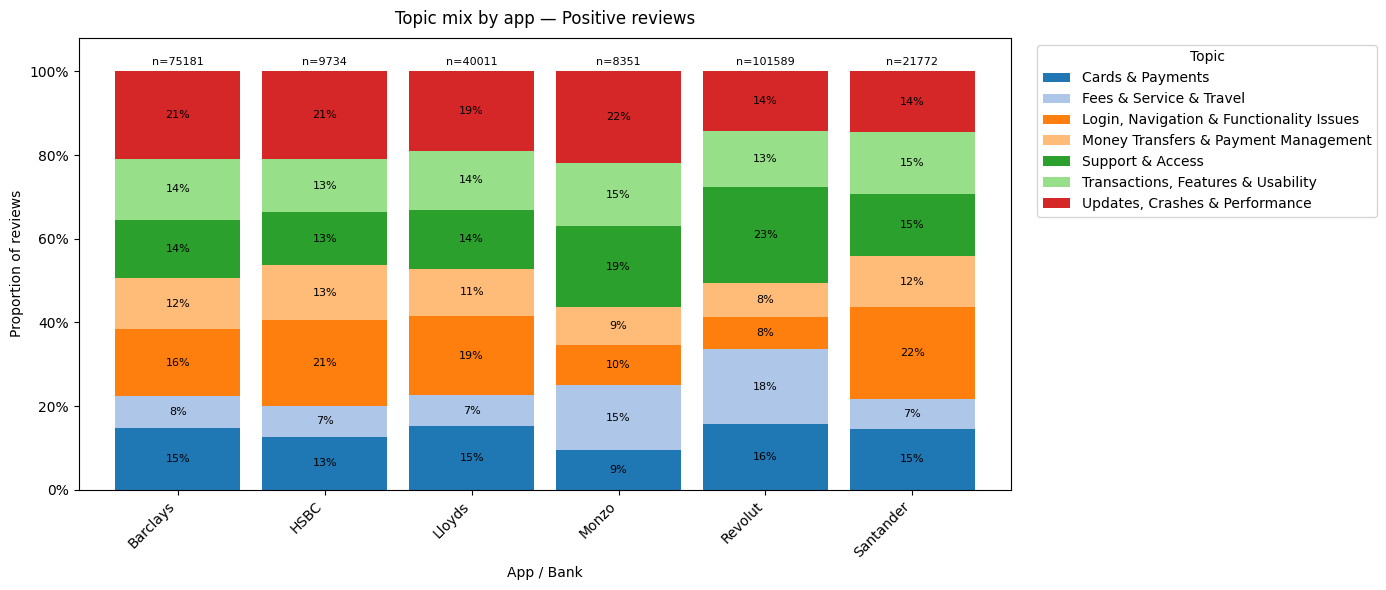

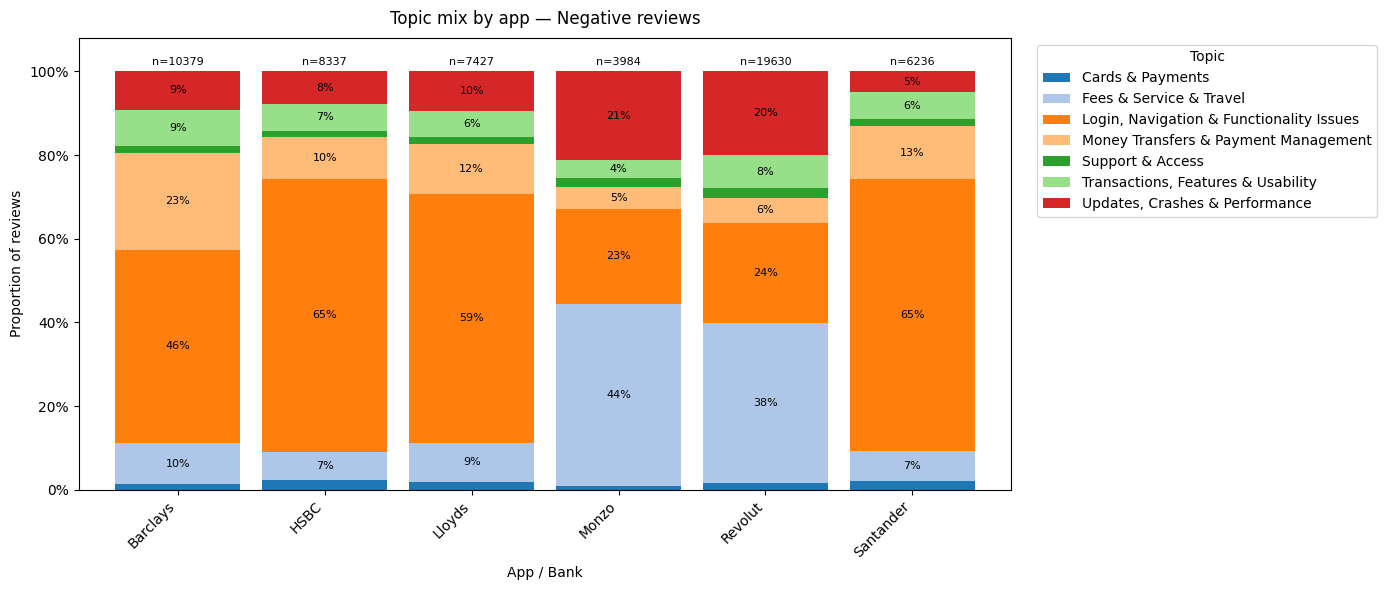

In [48]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_ALL"] != "Undefined"].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_ALL'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}

def topic_share_by_app(df, score, label_col= 'topic_label_ALL', min_reviews=0):
    tmp = (df[df['score'].isin(score)]
             .dropna(subset=[label_col,'app'])
             .groupby(['app',label_col])
             .size()
             .unstack(fill_value=0))
    tmp = tmp.reindex(index=apps, columns=topics, fill_value=0)

    totals = tmp.sum(axis=1)
    if min_reviews > 0:
        tmp = tmp.loc[totals >= min_reviews]
        totals = tmp.sum(axis=1)

    shares = tmp.div(totals.replace(0, np.nan), axis=0).fillna(0)
    return shares, totals

def plot_stacked(shares, totals, title, label_threshold=0.04):
    ax = shares.plot(
        kind='bar', stacked=True, figsize=(14,6), width=0.85,
        color=[topic_color[t] for t in shares.columns]
    )
    ax.set_title(title)
    ax.set_xlabel('App / Bank')
    ax.set_ylabel('Proportion of reviews')
    ax.set_ylim(0, 1.08)
    ax.set_title(title, pad=10)  
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.legend(title='Topic', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # --- % labels inside segments ---
    for i, (_, row) in enumerate(shares.iterrows()):
        cum = 0.0
        for t in shares.columns:
            v = float(row[t])
            if v > 0:
                if v >= label_threshold:  # avoid clutter for tiny slices
                    ax.text(
                        i, cum + v/2, f"{v:.0%}",
                        ha='center', va='center',
                        fontsize=8,
                        color='black'
                    )
                cum += v

    # --- show n on top of each bar ---
    for i, n in enumerate(totals.loc[shares.index]):
        ax.text(i, 1.01, f"n={int(n)}", ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# --- build data & plot ---
pos_shares, pos_totals = topic_share_by_app(df_sub, score = [4,5], label_col= 'topic_label_ALL', min_reviews=0)
neg_shares, neg_totals = topic_share_by_app(df_sub, score = [1,2], label_col= 'topic_label_ALL', min_reviews=0)

plot_stacked(pos_shares, pos_totals, "Topic mix by app — Positive reviews")
plot_stacked(neg_shares, neg_totals, "Topic mix by app — Negative reviews")

### Topic Distribution Analysis: Positive vs Negative Reviews

The topic mix reveals **distinct patterns between positive and negative reviews**, highlighting different user priorities based on their experience.

**Positive reviews emphasize:**
- **Transactions, Features & Usability** (13-23%): Users praise functional aspects when satisfied
- **Updates, Crashes & Performance** (14-22%): Stable performance drives positive feedback
- Relatively balanced topic distribution across all categories

**Negative reviews concentrate heavily on:**
- **Login, Navigation & Functionality Issues** (46-65%): Dominates complaints for traditional banks (Barclays, HSBC, Lloyds, Santander at ~46-65%)
- **Fees & Service & Travel** (38-44%): Major concern for digital banks (Monzo, Revolut at ~38-44%)
- **Updates, Crashes & Performance** (20-21%): Technical failures drive Monzo and Revolut complaints

**Key insights:**
- Traditional banks struggle most with **basic app usability and login functionality**
- Digital-first banks face criticism around **fees, service quality, and travel features**
- The dramatic shift in topic distribution between positive/negative reviews (e.g., Login issues: 16-22% positive vs 46-65% negative) confirms these topics are **critical pain points** rather than general discussion areas
- When apps work well, users praise features; when they fail, specific failure modes dominate feedback

**LDA_NEG - Topic distribution per app and scores**

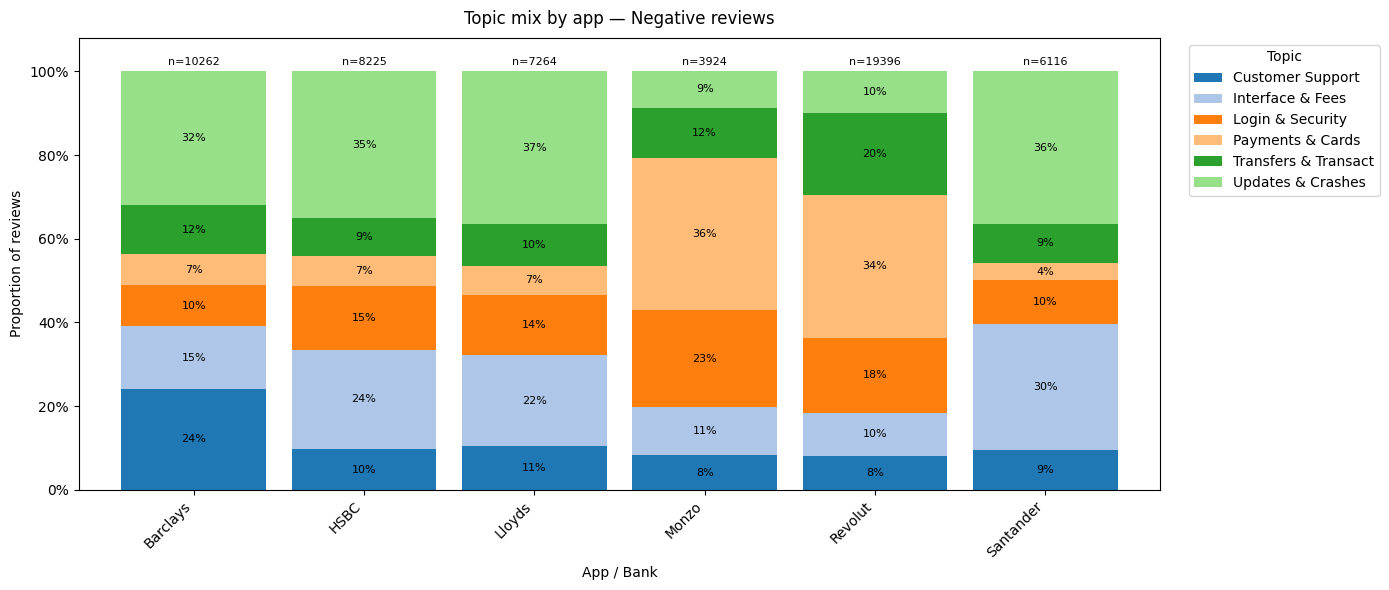

In [49]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_NEG"].notna()].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_NEG'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}


# --- build data & plot ---
neg_shares, neg_totals = topic_share_by_app(df_sub, score = [1,2], label_col= 'topic_label_NEG', min_reviews=0)
plot_stacked(neg_shares, neg_totals, "Topic mix by app — Negative reviews")

### Topic Distribution in Negative Reviews (Alternative View)

This visualization provides an alternative topic breakdown for negative reviews, revealing app-specific pain points:

**Traditional Banks (Barclays, HSBC, Lloyds, Santander):**
- **Updates & Crashes** (32-37%): The dominant complaint, indicating poor app stability and problematic updates
- **Customer Support** (10-24%): Barclays shows notably higher support complaints (24%) vs others (~10%)
- **Login & Security** (10-15%): Moderate concerns about authentication and access issues
- **Interface & Fees** (15-30%): UI/UX frustrations, with Santander particularly high (30%)

**Digital Banks (Monzo, Revolut):**
- **Payments & Cards** (34-36%): Primary frustration area, reflecting core functionality issues
- **Login & Security** (18-23%): Higher than traditional banks, suggesting authentication challenges
- **Transfers & Transactions** (12-20%): Revolut shows more transfer-related complaints (20%)
- **Updates & Crashes** (9-10%): Notably lower than traditional banks, indicating better technical stability

**Key contrasts:**
- Traditional banks struggle with **technical reliability** (updates/crashes dominate at 32-37%)
- Digital banks face **functional complaints** around payments/cards (34-36%), despite better stability
- Barclays has a **customer support problem** (24% vs ~10% for peers)
- Santander users particularly frustrated with **interface design** (30% vs 11-24% for others)

**LDA_POS - Topic distribution per app and scores**

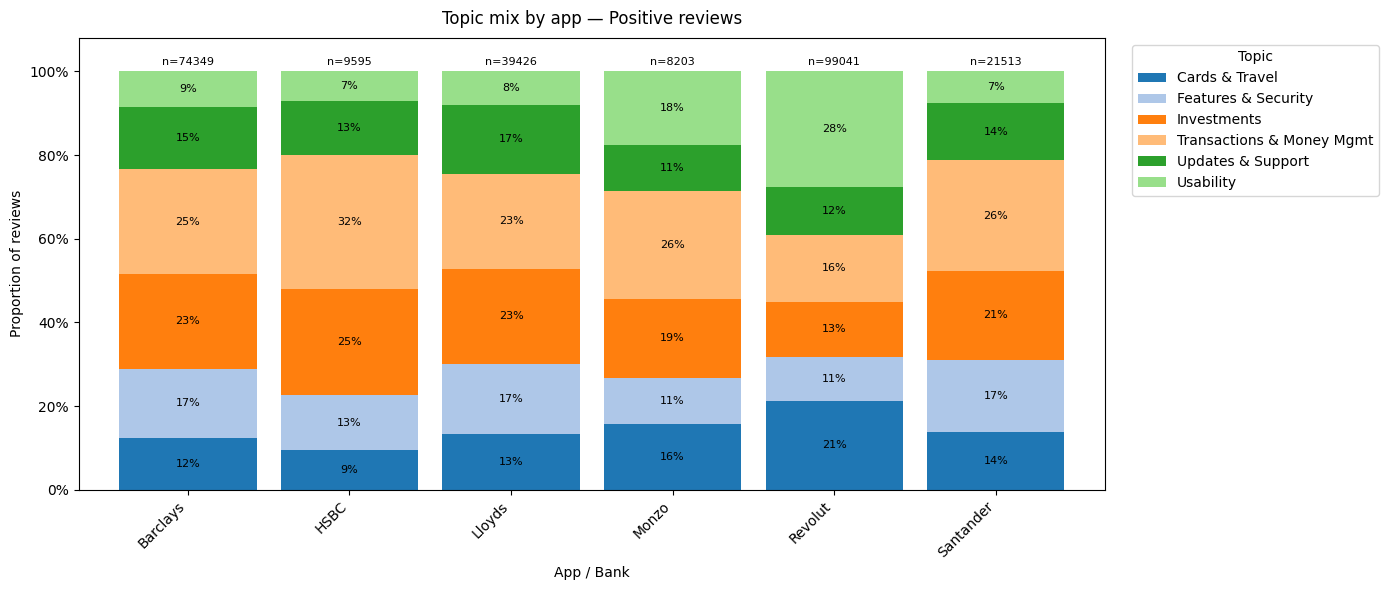

In [50]:
# Keep only rows where topic_label_ALL is not 'Undefined'
df_sub = df_final[df_final["topic_label_POS"].notna()].copy()

# define topics, apps and colors
topics = sorted(df_sub['topic_label_POS'].dropna().unique())
apps   = sorted(df_sub['app'].dropna().unique())

palette = plt.get_cmap('tab20').colors
topic_color = {t: palette[i % len(palette)] for i, t in enumerate(topics)}


# --- build data & plot ---
pos_shares, pos_totals = topic_share_by_app(df_sub, score = [4,5], label_col= 'topic_label_POS', min_reviews=0)
plot_stacked(pos_shares, pos_totals, "Topic mix by app — Positive reviews")

### Topic Distribution in Positive Reviews (Alternative View)

When users are satisfied, their praise focuses on different aspects than their complaints, revealing what drives positive banking app experiences:

**Universal praise areas across all apps:**
- **Investments** (19-25%): Consistently high praise, indicating this feature delights users when implemented well
- **Features & Security** (11-17%): Users appreciate robust security and feature richness
- **Transactions & Money Management** (16-32%): Core functionality that earns praise, especially HSBC (32%)

**App-specific strengths:**
- **Revolut**: Highest praise for **Cards & Travel** (21%) and **Usability** (28%), reflecting its strong international/travel positioning
- **HSBC**: Leads in **Transactions & Money Management** (32%), suggesting excellent account management tools
- **Monzo**: Strong **Usability** recognition (18%), confirming its user-friendly design reputation
- **Lloyds**: Balanced praise across categories, with slight edge in **Updates & Support** (17%)

**Key insight**: Positive reviews show more balanced topic distribution (no single category dominates >32%) compared to negative reviews where pain points can reach 65%. This suggests satisfied users appreciate **holistic app quality** across multiple dimensions, while dissatisfied users fixate on specific breaking points (login failures, crashes, fees).